In [3]:
from src.generate_data import Data
from src.evaluate import *
from src.models import *

import pandas as pd
import numpy as np
import sympy

from sklearn.preprocessing import LabelEncoder


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [6]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2], permutation_intervals=2)

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 2.58 s
Wall time: 3.06 s


In [7]:
%%time
train, val, test = data.get_splits(['1st_interval', 'skip', 'omit_distances', 'random_subsample'], [5, [1], [0.5, 0.5]])

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 180 train | 529 val | 2119 test
CPU times: total: 26.4 s
Wall time: 26.4 s


#### Peek at unshuffled train data

In [8]:
train_original[:20]

[['.._,,,.,..,,._.,', '.,__w,,..,,,,.__', '.,cr._...,,__.,.', 'V'],
 ['_,,.,_..,..,__,_', ',w,.u,_,_,,_,_,.', 'r_,,_,._.,,.,.__', 'R'],
 [',,____..__..,,_.', ',_,.wu.,._.,.,,,', '_.,_..,.._,_.,..', 'V'],
 [',_,____,,.._,,_.', '..,_...,,,__..__', '_d,.r,._.._..,,.', 'D'],
 ['__,_.,__,,.,__..', '...,,._,.,_,,,__', ',,_dr,__.,..,_._', 'D'],
 [',,,...,.,.._....', ',,wu..,,,,,__,_.', '.,_..,r..,_____,', 'R'],
 ['_,.,.,_,.,,,,._.', ',_,._..,____,.,.', ',,_,_.._,,_.__,.', 'V'],
 [',_.,.,,..,,_....', ',.w,.,__,.,___,_', '.,._,.,._,__._.,', 'V'],
 ['._,,.._...,.,,,,', '.._w.,.,,.,,.,..', ',r,__.,.,__,_,_,', 'R'],
 ['.,,.___,,_,,___.', '...w..u_,_..____', '..,,c_,r__,,,_.,', 'V'],
 [',,,_,,..,,,,._,.', ',,_,_._,.._.,_.,', ',..,.,.__,__,,,_', 'V'],
 ['..,,_.,._,_._,__', '.,,.,,..._,_,.,.', 'cr.,_,,_,.._.,,_', 'V'],
 [',,,.,,,._,_.,_.,', '__,__w,,_,__,__.', 'cr..,_,_,,_,.___', 'V'],
 ['._.,._,_.,,.__..', '_w,_,,_,._,,_.__', '.,.._.__..,,,._,', 'V'],
 ['___....,_.,.,_,,', '_._.wu,_.,,_.,_.', 'r,,__

In [9]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 8 | F2-uw 11 | F2-w 7 | F2-noop 9 | 
F3 cr:    F2-wu 10 | F2-uw 4 | F2-w 9 | F2-noop 12 | 
F3 r:    F2-wu 14 | F2-uw 10 | F2-w 15 | F2-noop 13 | 
F3 noop:    F2-wu 16 | F2-uw 11 | F2-w 15 | F2-noop 16 | 

Positive samples count: 79
Total samples count: 180
Positive class ratio: 0.4388888888888889


#### Peek at test data

In [10]:
test_original[:15]

[['._...,,.._.__..,', '__._.,__.,..,___', '_.,,,,____,r.,_.', 'R'],
 ['_._,,,_.._,.._,_', 'w_u_,_.__,_..,__', ',,_.__.__._,....', 'V'],
 ['._,,,._,_.,,,___', '._,_,,__,___,,..', '___._,,,..._,_,.', 'V'],
 [',..__,._,,__.,._', '_w_.____.,,.__,,', '.,.,.r,_.__,,_,,', 'R'],
 ['_,,,,,.__._,_.__', ',_....,._,_.w.__', '...,__.,,__,r,_.', 'R'],
 ['_._.,_,_,_.,,__,', '___,,,,,_w_,,.__', ',,,,__,__,__r_._', 'R'],
 ['.__..,,.,.._,...', ',,,._u,w..,.,.,.', ',__.,c,r_..._.._', 'V'],
 ['.,..,,,.,.___...', ',..,,..,,u.w_,,,', '_,,__.,__,.d,r_.', 'A'],
 ['_.,,._,..___,_,,', '____,_.,,,w._._.', ',,__,,_._,.,_..,', 'V'],
 ['_,_._,._.,.__.,.', '._.,._..,,_,w.,,', '.,._,.__.,_,.___', 'V'],
 ['..._...,.,.__.,_', '.,,,__.,_.,_,,__', ',,_,,...r,_,.,,_', 'R'],
 ['..,._...________', '_,,,.w....__,,_,', '._.,.,,_,__.___,', 'V'],
 ['__..__..__.,__..', '.._,.,..__w.u._.', '.,,_,...,,,,..,.', 'V'],
 [',.,_,,_,_,,,_.__', '_.,w,u_,,..,.,_.', ',_d_r,_.___._.__', 'V'],
 ['.__.,,_,.,____,,', '_.,__,.,,..__,__', '.,._.

In [11]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 74 | F2-uw 77 | F2-w 92 | F2-noop 93 | 
F3 cr:    F2-wu 75 | F2-uw 77 | F2-w 84 | F2-noop 92 | 
F3 r:    F2-wu 89 | F2-uw 82 | F2-w 262 | F2-noop 267 | 
F3 noop:    F2-wu 83 | F2-uw 89 | F2-w 285 | F2-noop 298 | 

Positive samples count: 962
Total samples count: 2119
Positive class ratio: 0.4539877300613497


#### Peek at val data

In [12]:
val_original[:15]

[['..__,____,._,,,_', '.____.,_w,u,__..', '_.,,._._,_,c_r..', 'V'],
 [',_._..,__,.,_,._', ',,_,.,,u.w..,,_,', '_..__.___.,_.._,', 'V'],
 [',__._,,,_,_._,..', '___w_u,,.,.,._..', 'c_r.,_,___,,,..,', 'V'],
 ['..,,,__,,.,,.._,', '.,,,.,_,..,__.,.', ',,,._._._.__,,,_', 'V'],
 ['._,._,_,_.,,_.__', ',.,..w_.__.,._,_', ',,r__..,,,_.._,_', 'R'],
 ['_,,.,__._,.._.,.', ',,_._.,__,,,,___', '__._.._,___r_,_.', 'R'],
 ['..._,_..,,._.___', ',..,,w.u,,,_____', ',_,__,._,.__.,_.', 'V'],
 ['_._,___._,,,__._', ',,__,,,.,_,.._.,', '.,.,._,,.__r.._.', 'R'],
 ['_.,.,._.___,,._,', '__,..._._.__,,.,', '____,,,._,__,,_,', 'V'],
 ['_.,.,_..,__.___,', ',__,.__,____.___', ',,,.,.,,,._,.,._', 'V'],
 ['__,_._._,_,__..,', '_,.______.,.u,w_', '..,,...___,__,,,', 'V'],
 [',,_,.__,..,.,,..', '_..,..,,_..,w_u_', '_.,_._,.,r.._.,,', 'R'],
 ['..___.__,__.,_..', 'u.w_,.,__,,,_.,,', '.,.,.,..____,_,_', 'V'],
 [',.____,,____.,,,', '._,,___,,,._,_,,', '.,__,_r,._._..__', 'R'],
 ['_,,__._,.,_,_,._', ',._,,,w._.,,__._', '.,..,

In [13]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 24 | F2-uw 21 | F2-w 13 | F2-noop 19 | 
F3 cr:    F2-wu 23 | F2-uw 21 | F2-w 21 | F2-noop 20 | 
F3 r:    F2-wu 16 | F2-uw 23 | F2-w 62 | F2-noop 81 | 
F3 noop:    F2-wu 29 | F2-uw 23 | F2-w 61 | F2-noop 72 | 

Positive samples count: 235
Total samples count: 529
Positive class ratio: 0.444234404536862


#### Send label arrays to device

In [14]:

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train


y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


#### Get data in normal format (same as CNN format)

In [15]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [16]:
x_train_normal[0].shape

torch.Size([180, 128])

#### Get data in convolutional format, send to device

In [17]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [18]:
x_train_cnn[0].shape

torch.Size([180, 160])

#### Get data in LSTM format, send to device

In [19]:
x_train_lstm = data.to_lstm_format(x_train, padding_left_size=2, padding_right_size=0)
x_val_lstm = data.to_lstm_format(x_val, padding_left_size=0, padding_right_size=2)
x_test_lstm = data.to_lstm_format(x_test, padding_left_size=0, padding_right_size=2)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

In [20]:
x_train_lstm[0].shape

torch.Size([180, 18, 8])

### Define training parameters

In [21]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "all_filters"

### Define training procedure for each model

In [22]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        #criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([(1-pos_train_ratio)/pos_train_ratio]).to(device))
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision_by_cases(model, x_test, y_test, test_original))
        recalls.append(get_recall_by_cases(model, x_test, y_test, test_original))
        f1_scores.append(get_f1_by_cases(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | METRICS:")
        print("Accuracy ", accuracies[-1]['Overall'])
        print("Precision ", precisions[-1]['Overall'])
        print("Recalls ", recalls[-1]['Overall'])
        print("F1_scores ", f1_scores[-1]['Overall'])
        print("---------------------------------------------------------------------")
        
    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [23]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores,  cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.9216611609249646
Precision  0.8189075387607018
Recalls  0.8296978503939129
F1_scores  0.8242673826627922
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.9660217083529967
Precision  0.8784347671539942
Recalls  0.9184845224173754
F1_scores  0.8980133301109062
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.9631901840490797
Precision  0.879933608058608
Recalls  0.9441031089329519
F1_scores  0.9108896189248864
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.950920245398773
Precision  0.8359250965121914
Recalls  0.8656091099911325
F1_scores  0.8505081779086244
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.9145823501651722
Precision  0.8536367473935826
Recalls  0.8849822368642593
F1

In [24]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 16, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.7984898537045776
Precision  0.5914146879433606
Recalls  0.6321814309103946
F1_scores  0.6111189434561204
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.5460122699386503
Precision  0.1365675165250236
Recalls  0.25
F1_scores  0.17664122137404578
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.903728173666824
Precision  0.7548812709996392
Recalls  0.7326030952480561
F1_scores  0.7435753520881473
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.8787163756488909
Precision  0.7648966035728104
Recalls  0.7885106811333917
F1_scores  0.7765241579820262
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.7909391222274658
Precision  0.39464309578325596
Recalls  0.45426009383874555
F1_scores  0

In [25]:
%%time
deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores, deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.5455403492213308
Precision  0.1364494806421152
Recalls  0.2497839239412273
F1_scores  0.17648854961832058
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.5460122699386503
Precision  0.13650306748466257
Recalls  0.25
F1_scores  0.17658730158730157
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.5799905615856537
Precision  0.3849765652943206
Recalls  0.38190490908156516
F1_scores  0.3834345856037642
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.5365738555922605
Precision  0.23221475218434456
Recalls  0.25778991055635075
F1_scores  0.24433490024622861
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.5681925436526664
Precision  0.35448188129222313
Recalls  0.3377583664195254
F1_sco

In [26]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.5795186408683342
Precision  0.3199335007845646
Recalls  0.3342135012919897
F1_scores  0.3269176351443384
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.5431807456347334
Precision  0.23023490208984695
Recalls  0.2518070132115076
F1_scores  0.24053826520892735
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.5427088249174139
Precision  0.22508419849215178
Recalls  0.25003920237066307
F1_scores  0.23690634203667713
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.33034450212364325
Precision  0.08258612553091081
Recalls  0.25
F1_scores  0.12415750266051792
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.61113732892874
Precision  0.36176357557586136
Recalls  0.3673803163129006
F1_scor

In [27]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.5559226050023596
Precision  0.29424429389940354
Recalls  0.28441457331595743
F1_scores  0.2892459445157276
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.5771590372817367
Precision  0.35632271889074957
Recalls  0.32284086376842774
F1_scores  0.33875648601945785
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.5596979707409155
Precision  0.3585956835137177
Recalls  0.39880952380952384
F1_scores  0.37763504237758105
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.5483718735252477
Precision  0.33193615640058927
Recalls  0.3491513282880189
F1_scores  0.3403261769435471
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.5488437942425672
Precision  0.3115432742440042
Recalls  0.285955774

# Evaluation

In [28]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [41]:
imprimirMetricas(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score  \
0                     CNN  0.983955   0.924090  0.989623  0.955734   
1                    LSTM  0.915526   0.826174  0.881629  0.853001   
2  DeepSet(like in paper)  0.579991   0.384977  0.381905  0.383435   
3   DeepSet(sum at start)  0.622463   0.436745  0.400048  0.417592   
4             Feedforward  0.577159   0.356323  0.322841  0.338756   

   Precision clase A  Recall clase A  Precision clase D  Recall clase D  \
0           0.697248        0.987013           1.000000        1.000000   
1           0.504854        0.675325           0.941799        0.978022   
2           0.125000        0.038961           0.250000        0.304348   
3           0.250000        0.025974           0.264706        0.300000   
4           0.250000        0.012987           0.076923        0.090909   

   Precision clase R  Recall clase R  Precision clase V  Recall clase V  
0           1.000000        1.000000           0.99911

## Accuracies per CNN model

In [30]:
get_stats_per_model_multiclass(cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, ['CNN #' + str(i) for i in range(len(cnn_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,CNN #0,0.921661,0.824267,0.818908,0.829698,0.507937,0.916084,0.858896,0.992714,0.415584,0.956204,1.000000,0.947003
1,CNN #1,0.966022,0.898013,0.878435,0.918485,0.574257,0.958115,1.000000,0.981366,0.753247,0.958115,1.000000,0.962576
2,CNN #2,0.963190,0.910890,0.879934,0.944103,0.607143,0.943590,0.970833,0.998168,0.883117,0.943590,0.998571,0.951134
3,CNN #3,0.950920,0.850508,0.835925,0.865609,0.377358,1.000000,1.000000,0.966342,0.519481,1.000000,1.000000,0.942956
4,CNN #4,0.914582,0.869027,0.853637,0.884982,0.584270,1.000000,0.855569,0.974708,0.675325,1.000000,0.998571,0.866033
5,CNN #5,0.864087,0.676905,0.689560,0.664706,0.500000,0.518072,0.748394,0.991773,0.051948,0.651515,0.998571,0.956790
6,CNN #6,0.983483,0.944807,0.933807,0.956069,0.747126,1.000000,0.998573,0.989529,0.844156,1.000000,1.000000,0.980121
7,CNN #7,0.961774,0.886207,0.866198,0.907163,0.495238,0.994565,0.997151,0.977837,0.675325,1.000000,1.000000,0.953328
8,CNN #8,0.975460,0.934940,0.903892,0.968198,0.625000,1.000000,0.998573,0.991993,0.909091,1.000000,1.000000,0.963699
9,CNN #9,0.963190,0.915306,0.880064,0.953488,0.544715,1.000000,0.987306,0.988235,0.870130,1.000000,1.000000,0.943820


## Accuracies per LSTM model

In [31]:
get_stats_per_model_multiclass(lstm_accuracies, lstm_precisions,lstm_recall, lstm_f1_scores, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,LSTM #0,0.798490,0.611119,0.591415,0.632181,0.171053,0.443396,0.953237,0.797972,0.168831,0.626667,0.757143,0.976085
1,LSTM #1,0.546012,0.176641,0.136568,0.250000,0.000000,0.000000,0.000000,0.546270,0.000000,0.000000,0.000000,1.000000
2,LSTM #2,0.903728,0.743575,0.754881,0.732603,0.333333,0.877193,0.868895,0.940104,0.077922,0.943396,0.965714,0.943380
3,LSTM #3,0.878716,0.776524,0.764897,0.788511,0.461538,0.781726,0.912908,0.903414,0.467532,0.895349,0.838571,0.952590
4,LSTM #4,0.790939,0.422358,0.394643,0.454260,0.000000,0.000000,0.622498,0.956075,0.000000,0.000000,0.932857,0.884183
5,LSTM #5,0.891930,0.812405,0.809461,0.815371,0.560000,0.842640,0.938710,0.896496,0.545455,0.922222,0.831429,0.962380
6,LSTM #6,0.805569,0.445802,0.432420,0.460039,0.142857,0.000000,0.669165,0.917657,0.012987,0.000000,0.892857,0.934313
7,LSTM #7,0.905616,0.732254,0.733461,0.731051,0.384615,0.605839,0.990840,0.952548,0.259740,0.754545,0.927143,0.982774
8,LSTM #8,0.880132,0.827300,0.796485,0.860594,0.459459,0.937500,0.857143,0.931839,0.662338,0.961538,0.951429,0.867072
9,LSTM #9,0.873525,0.707821,0.707723,0.707920,0.333333,0.708920,0.848366,0.940271,0.155844,0.825137,0.927143,0.923556


## Accuracies per DeepSets V1 model

In [32]:
get_stats_per_model_multiclass(deepset_accuracies, deepset_precisions,deepset_recall, deepset_f1_scores, ['DEEPSETS #' + str(i) for i in range(len(deepset_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEEPSETS #0,0.545540,0.176489,0.136449,0.249784,0.000000,0.000000,0.000000,0.545798,0.000000,0.000000,0.000000,0.999136
1,DEEPSETS #1,0.546012,0.176587,0.136503,0.250000,0.000000,0.000000,0.000000,0.546012,0.000000,0.000000,0.000000,1.000000
2,DEEPSETS #2,0.579991,0.383435,0.384977,0.381905,0.125000,0.250000,0.571046,0.593861,0.038961,0.304348,0.306475,0.877836
3,DEEPSETS #3,0.536574,0.244335,0.232215,0.257790,0.000000,0.000000,0.370732,0.558127,0.000000,0.000000,0.109353,0.921807
4,DEEPSETS #4,0.568193,0.345918,0.354482,0.337758,0.166667,0.137931,0.513089,0.600241,0.038961,0.142857,0.290801,0.878414
5,DEEPSETS #5,0.545068,0.311956,0.308108,0.315901,0.052632,0.118644,0.479592,0.581565,0.012987,0.125000,0.277696,0.847922
6,DEEPSETS #6,0.535630,0.351274,0.356579,0.346125,0.166667,0.258065,0.430155,0.571429,0.012987,0.275862,0.279539,0.816112
7,DEEPSETS #7,0.531855,0.334853,0.330797,0.339009,0.117647,0.210526,0.419162,0.575853,0.025974,0.235294,0.302594,0.792174
8,DEEPSETS #8,0.579047,0.383595,0.377675,0.389704,0.095238,0.304348,0.506775,0.604338,0.025974,0.368421,0.270231,0.894189
9,DEEPSETS #9,0.545068,0.176390,0.136396,0.249568,0.000000,0.000000,0.000000,0.545583,0.000000,0.000000,0.000000,0.998271


## Accuracies per DeepSets V2 model

In [33]:
get_stats_per_model_multiclass(deepsetv2_accuracies, deepsetv2_precisions,deepsetv2_recall, deepsetv2_f1_scores, ['DEESETS V2 #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEESETS V2 #0,0.579519,0.326918,0.319934,0.334214,0.000000,0.155844,0.504505,0.619385,0.000000,0.166667,0.260465,0.909722
1,DEESETS V2 #1,0.543181,0.240538,0.230235,0.251807,0.000000,0.000000,0.372881,0.548058,0.000000,0.000000,0.031429,0.975799
2,DEESETS V2 #2,0.542709,0.236906,0.225084,0.250039,0.000000,0.000000,0.354839,0.545498,0.000000,0.000000,0.015714,0.984443
3,DEESETS V2 #3,0.330345,0.124158,0.082586,0.250000,0.000000,0.000000,0.330345,0.000000,0.000000,0.000000,1.000000,0.000000
4,DEESETS V2 #4,0.611137,0.364550,0.361764,0.367380,0.240000,0.000000,0.567961,0.639093,0.233766,0.000000,0.334286,0.901469
5,DEESETS V2 #5,0.612081,0.342563,0.346731,0.338493,0.186047,0.000000,0.565728,0.635152,0.103896,0.000000,0.344286,0.905791
6,DEESETS V2 #6,0.595092,0.307700,0.300028,0.315775,0.045455,0.000000,0.519685,0.634971,0.025974,0.000000,0.377143,0.859983
7,DEESETS V2 #7,0.546012,0.176587,0.136503,0.250000,0.000000,0.000000,0.000000,0.546012,0.000000,0.000000,0.000000,1.000000
8,DEESETS V2 #8,0.545068,0.239676,0.230178,0.249991,0.000000,0.000000,0.375000,0.545713,0.000000,0.000000,0.004286,0.995678
9,DEESETS V2 #9,0.544597,0.176291,0.136342,0.249352,0.000000,0.000000,0.000000,0.545369,0.000000,0.000000,0.000000,0.997407


## Accuracies per FeedForward model

In [34]:
get_stats_per_model_multiclass(feedforward_accuracies, feedforward_precisions,feedforward_recall, feedforward_f1_scores, ['FEED FORWARD #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,FEED FORWARD #0,0.555923,0.289246,0.294244,0.284415,0.125000,0.000000,0.474874,0.577103,0.012987,0.000000,0.270000,0.854671
1,FEED FORWARD #1,0.577159,0.338756,0.356323,0.322841,0.250000,0.076923,0.493392,0.604976,0.012987,0.090909,0.322767,0.864701
2,FEED FORWARD #2,0.559698,0.377635,0.358596,0.398810,0.000000,0.384615,0.477099,0.572668,0.000000,0.500000,0.178571,0.916667
3,FEED FORWARD #3,0.548372,0.340326,0.331936,0.349151,0.000000,0.333333,0.438017,0.556395,0.000000,0.363636,0.076259,0.956710
4,FEED FORWARD #4,0.548844,0.298202,0.311543,0.285956,0.000000,0.120000,0.571429,0.554745,0.000000,0.125000,0.029240,0.989583
5,FEED FORWARD #5,0.547900,0.336643,0.338914,0.334403,0.181818,0.166667,0.415274,0.591898,0.051948,0.181818,0.252540,0.851304
6,FEED FORWARD #6,0.562529,0.343817,0.381246,0.313080,0.333333,0.107143,0.505415,0.579093,0.025974,0.107143,0.203193,0.916010
7,FEED FORWARD #7,0.546956,0.247393,0.242055,0.252971,0.000000,0.000000,0.418605,0.549615,0.000000,0.000000,0.025714,0.986171
8,FEED FORWARD #8,0.482303,0.317654,0.303018,0.333776,0.000000,0.333333,0.329653,0.549086,0.000000,0.333333,0.298999,0.702773
9,FEED FORWARD #9,0.561586,0.365532,0.379232,0.352787,0.250000,0.192308,0.469880,0.604741,0.025974,0.212766,0.343612,0.828797


# Training evolution

### CNN

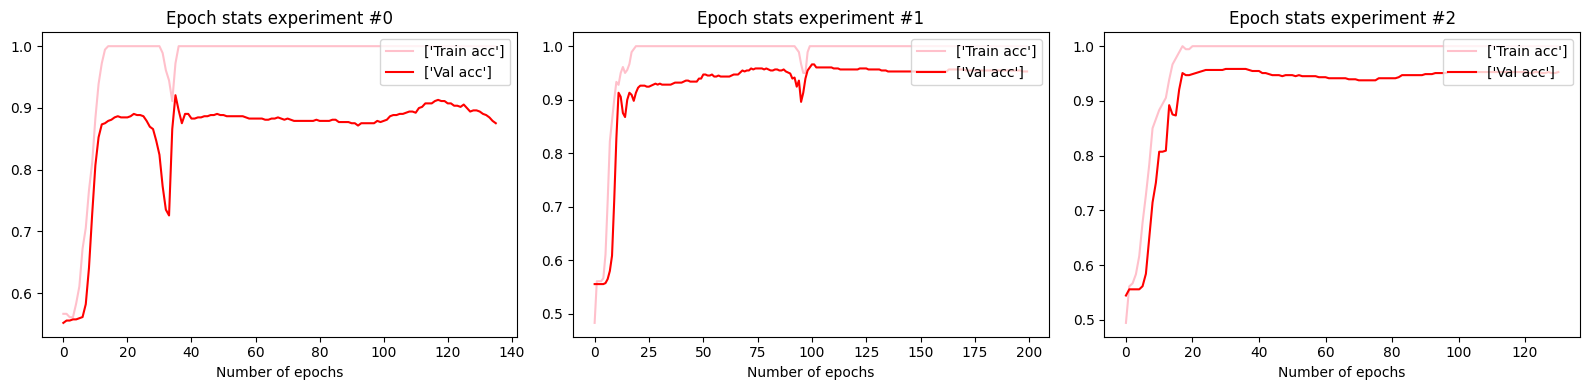

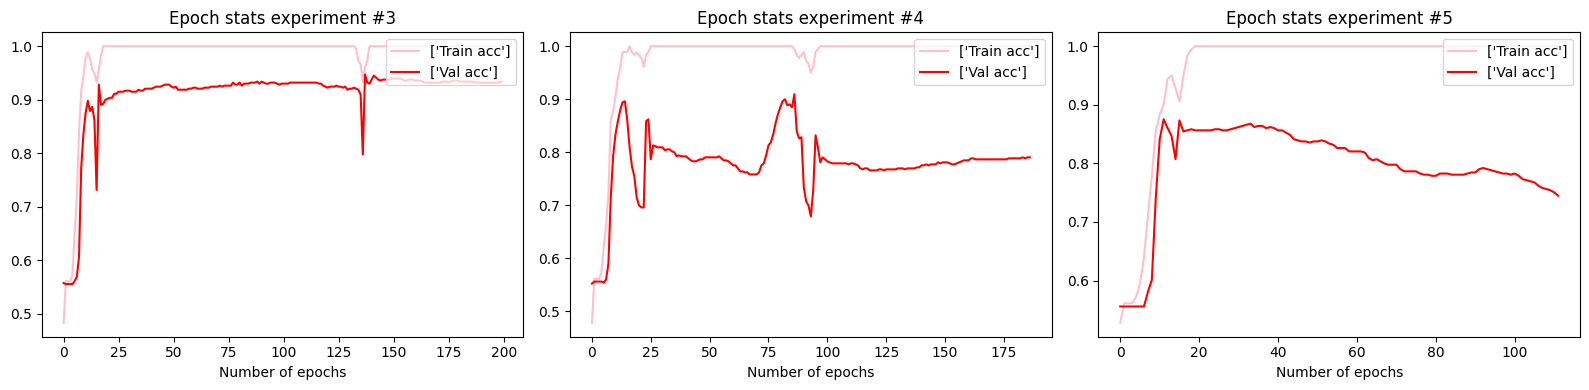

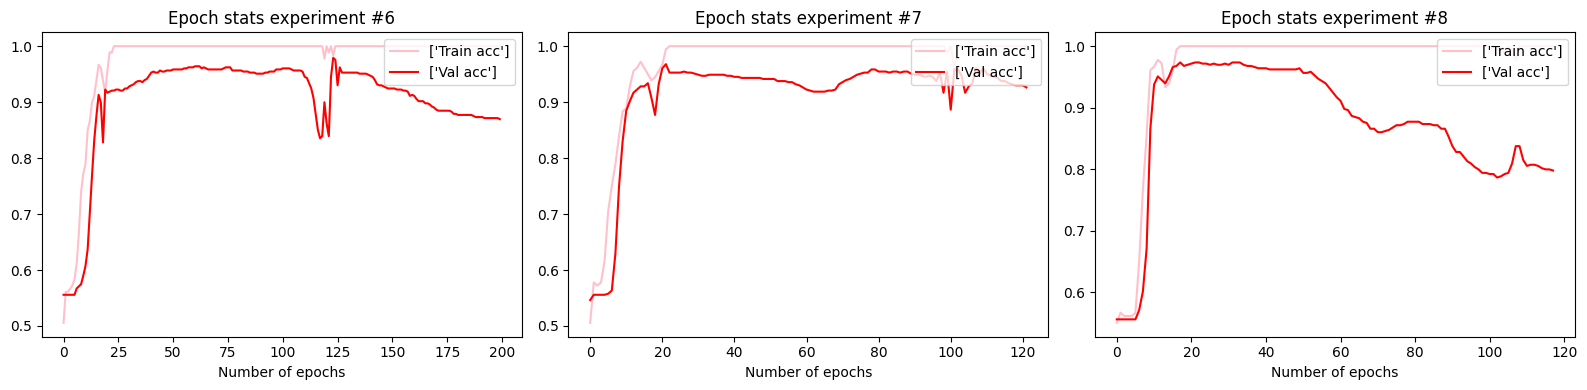

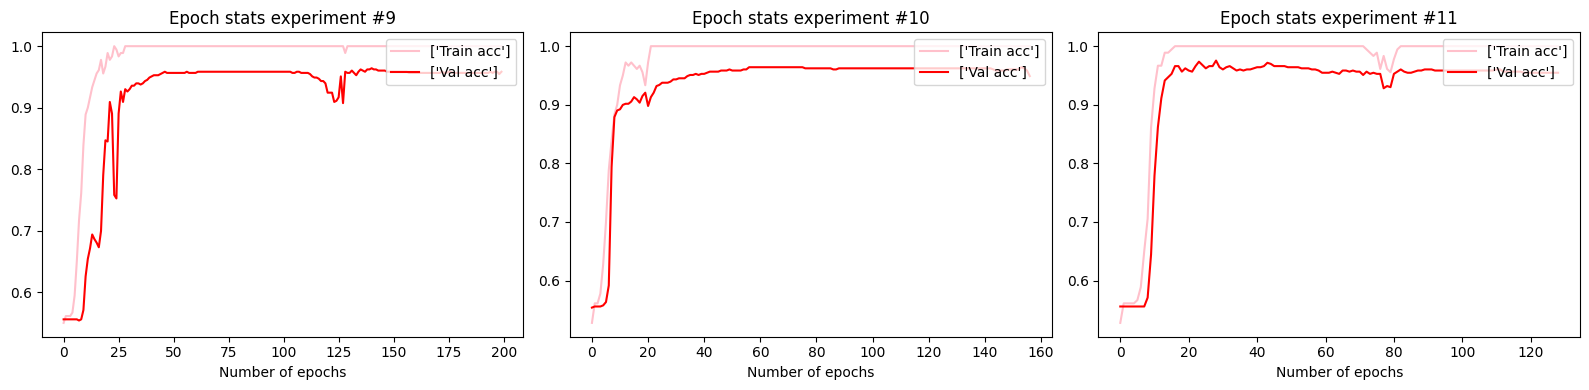

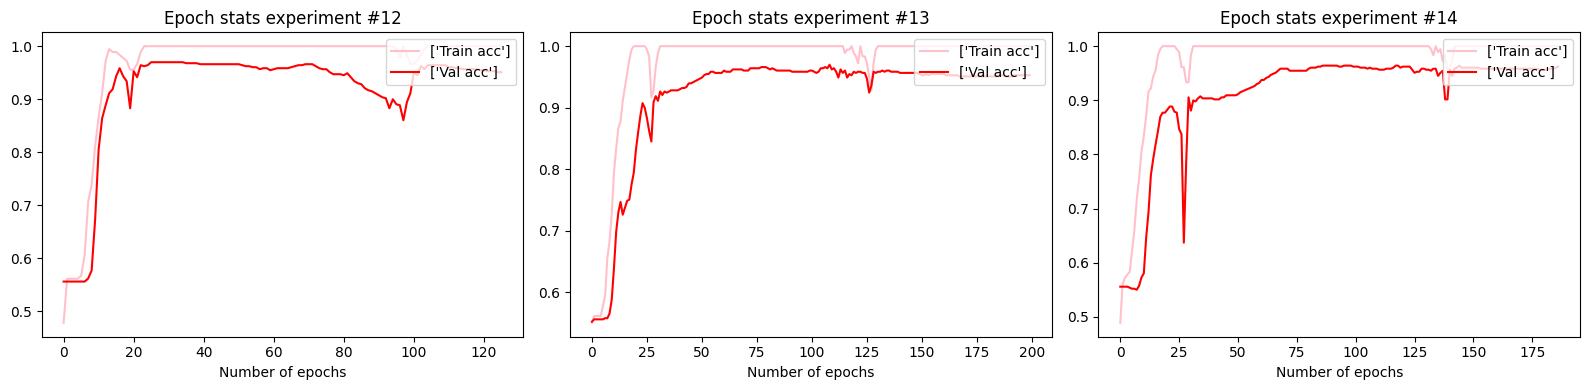

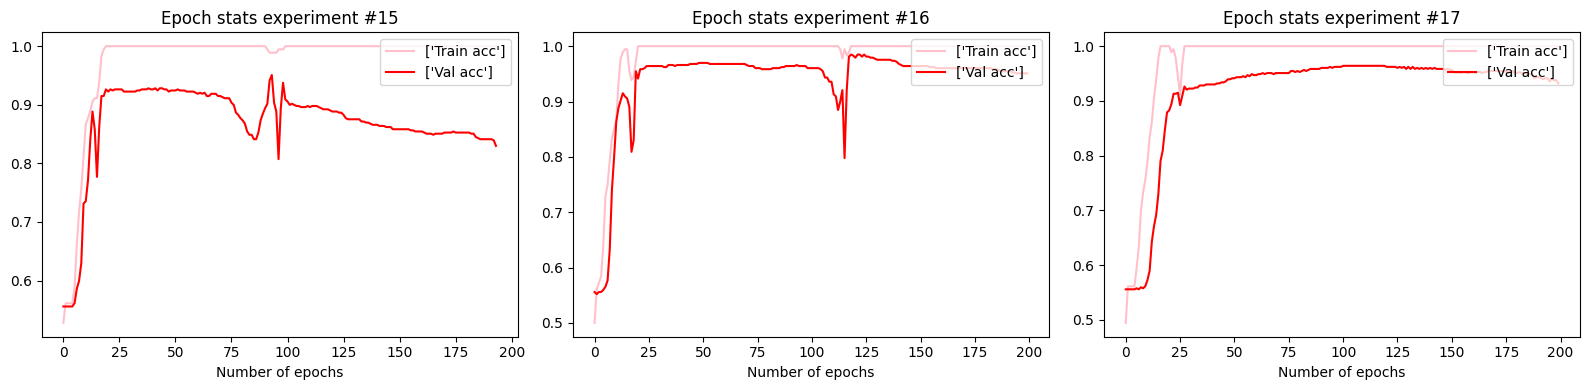

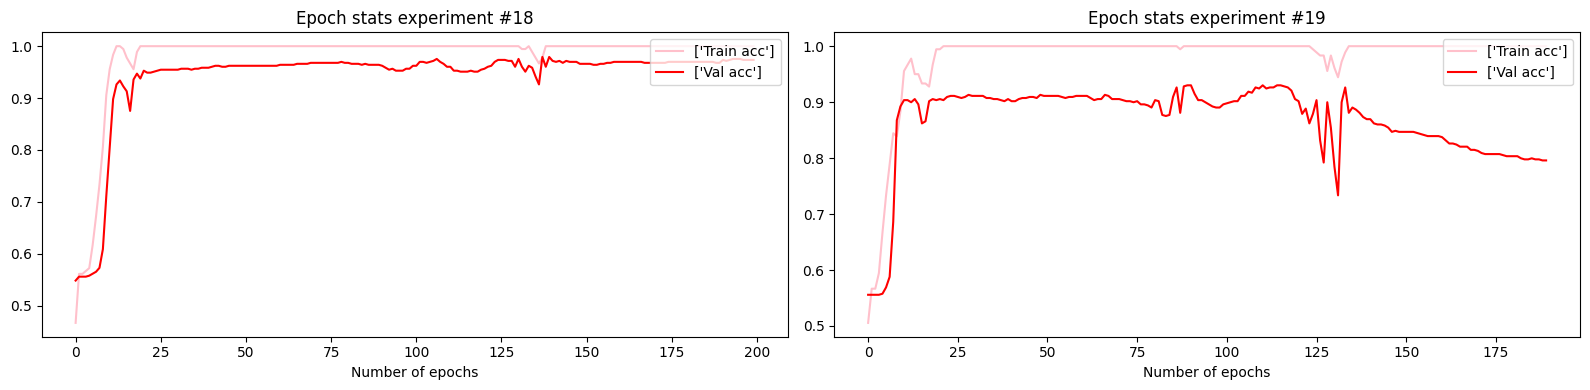

In [35]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

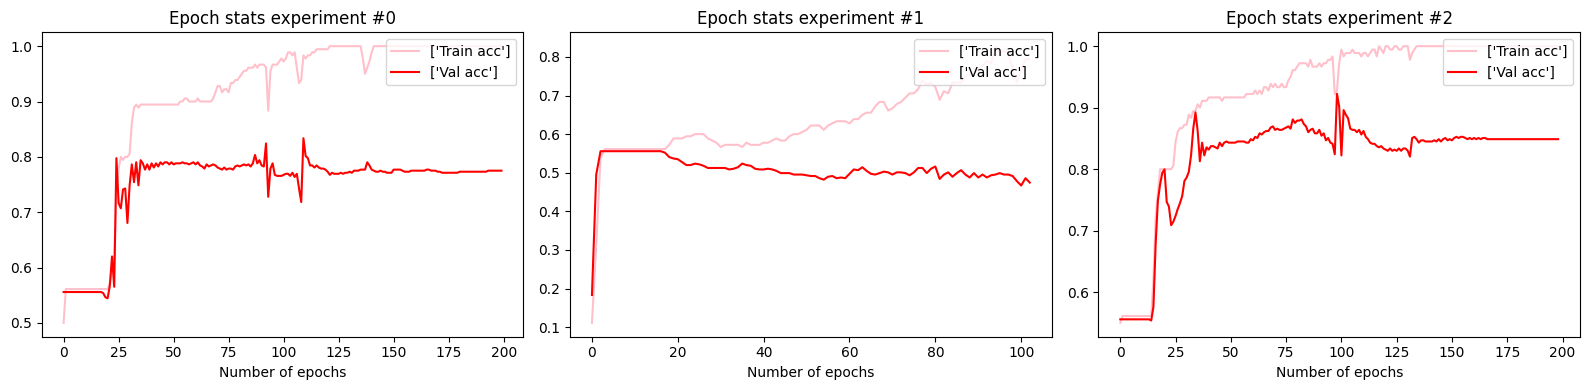

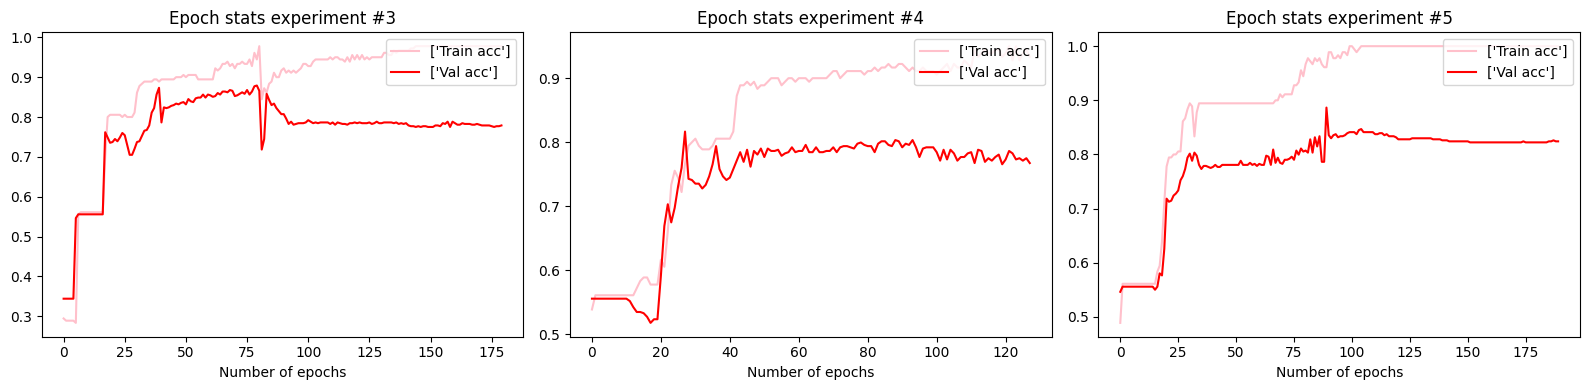

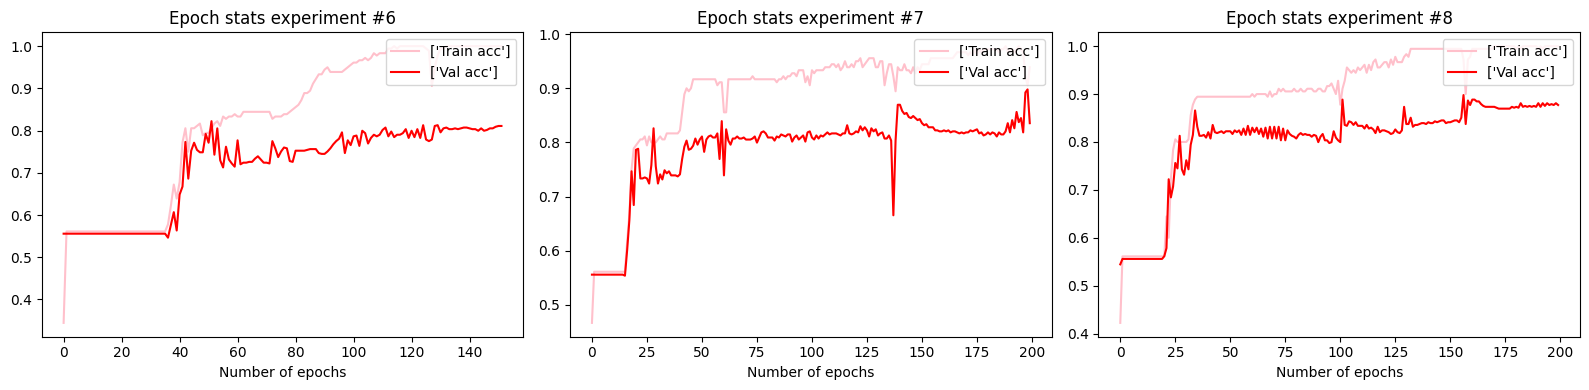

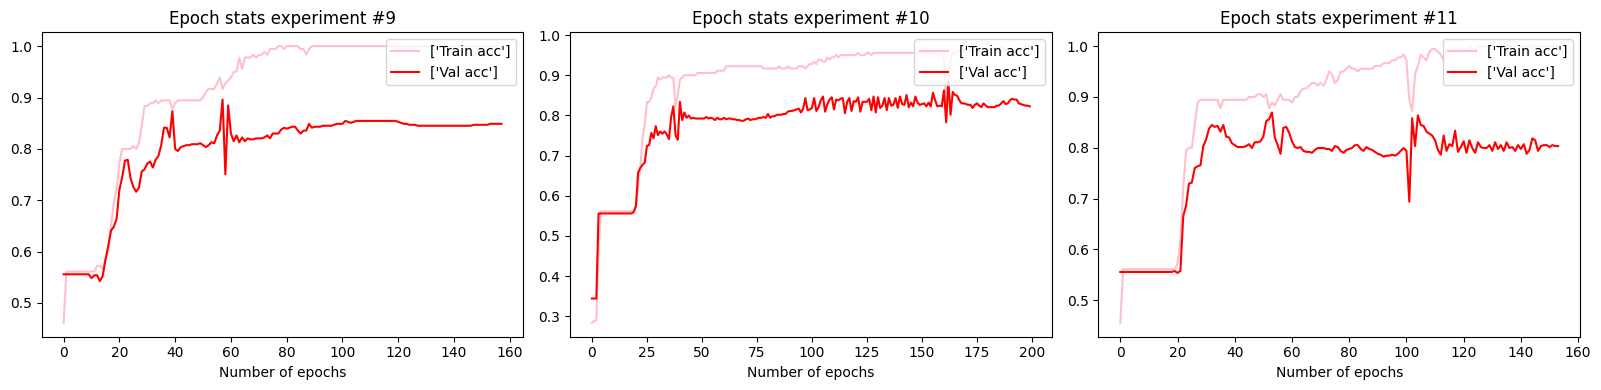

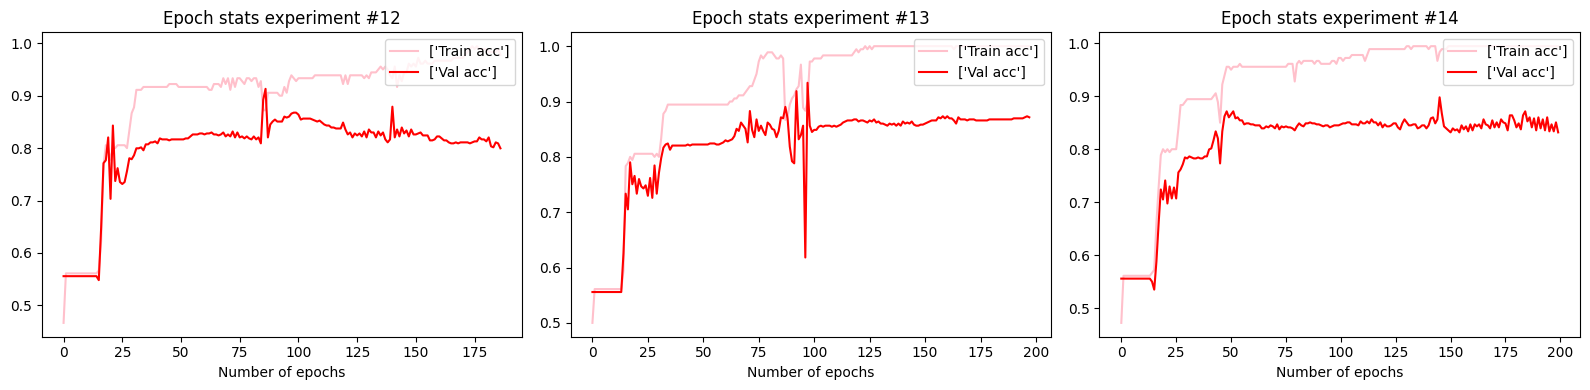

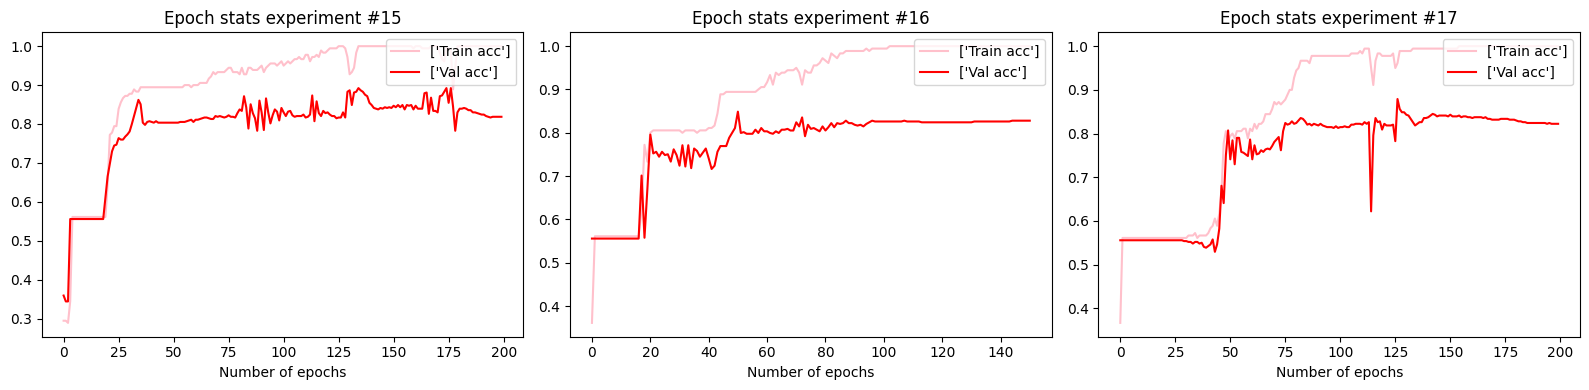

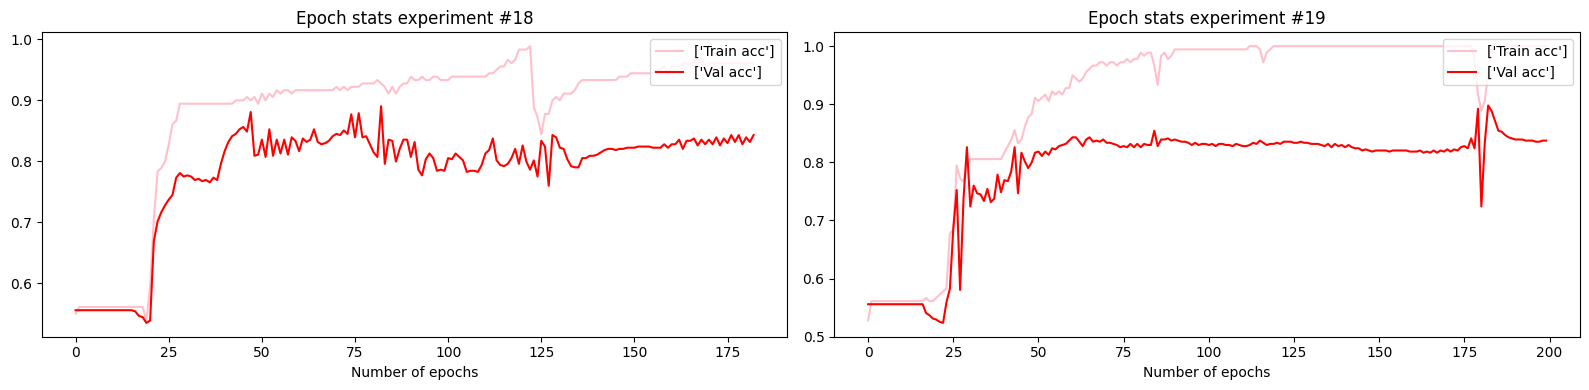

In [36]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

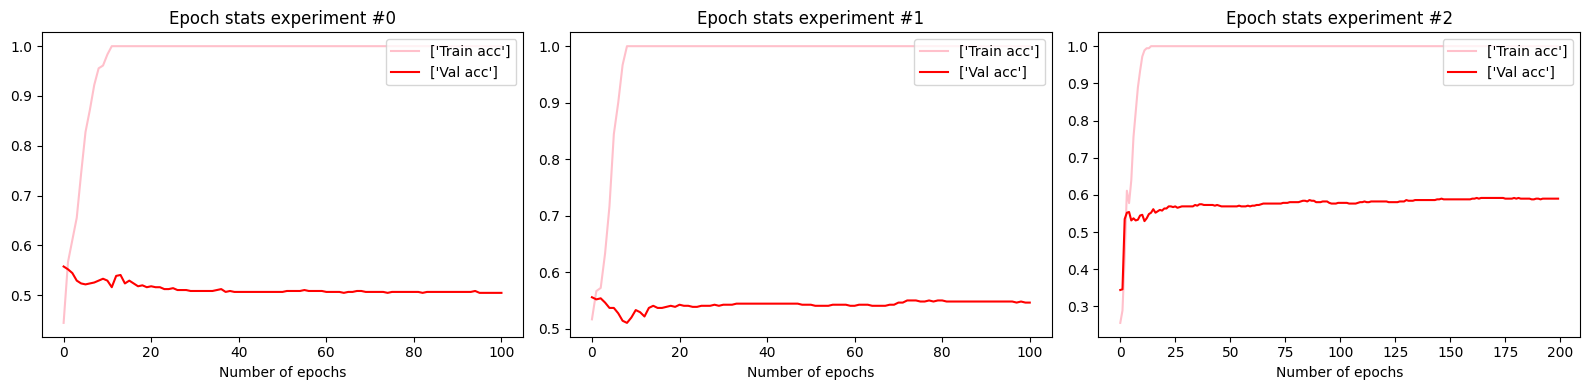

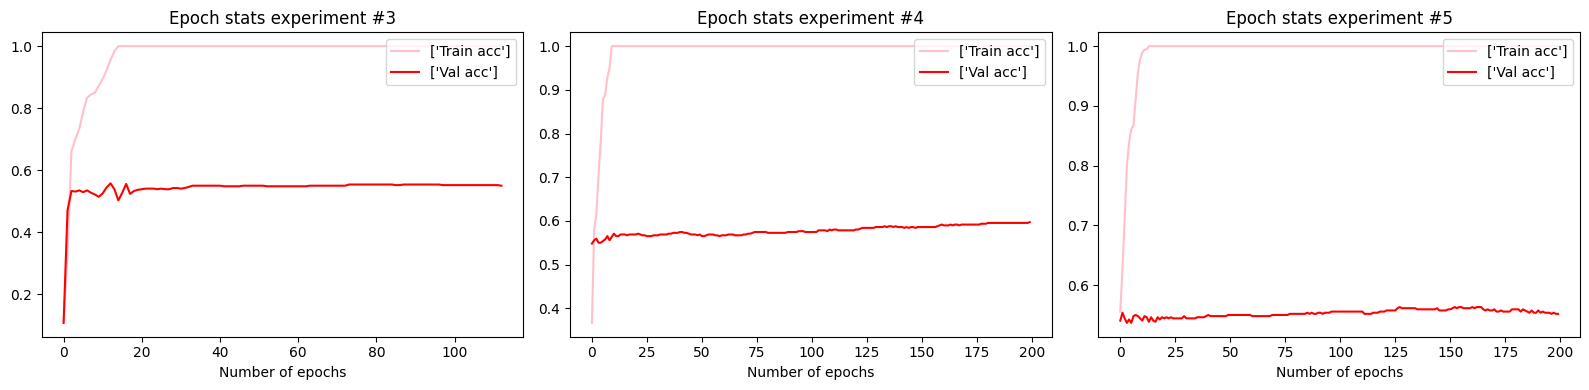

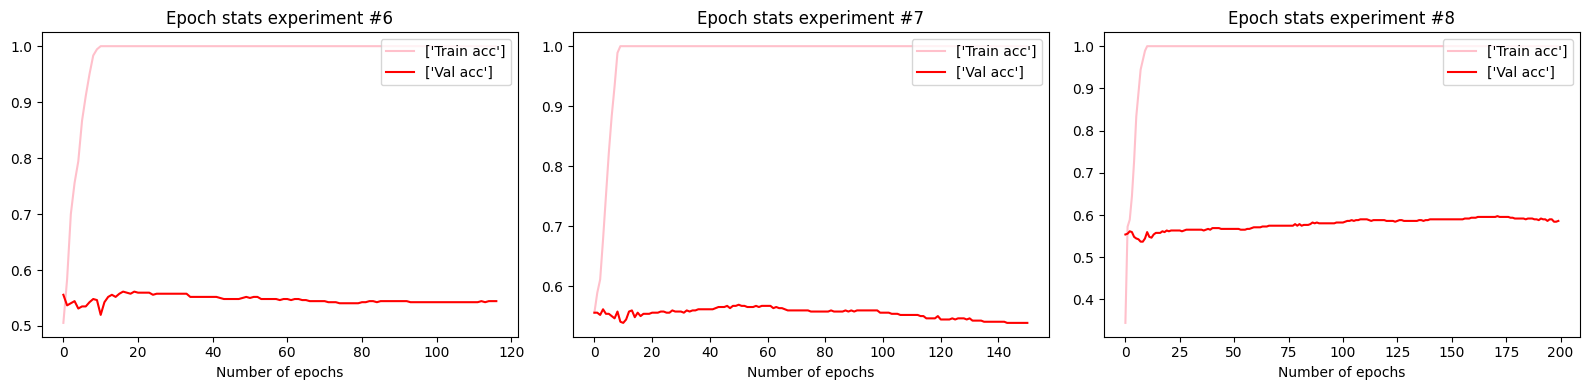

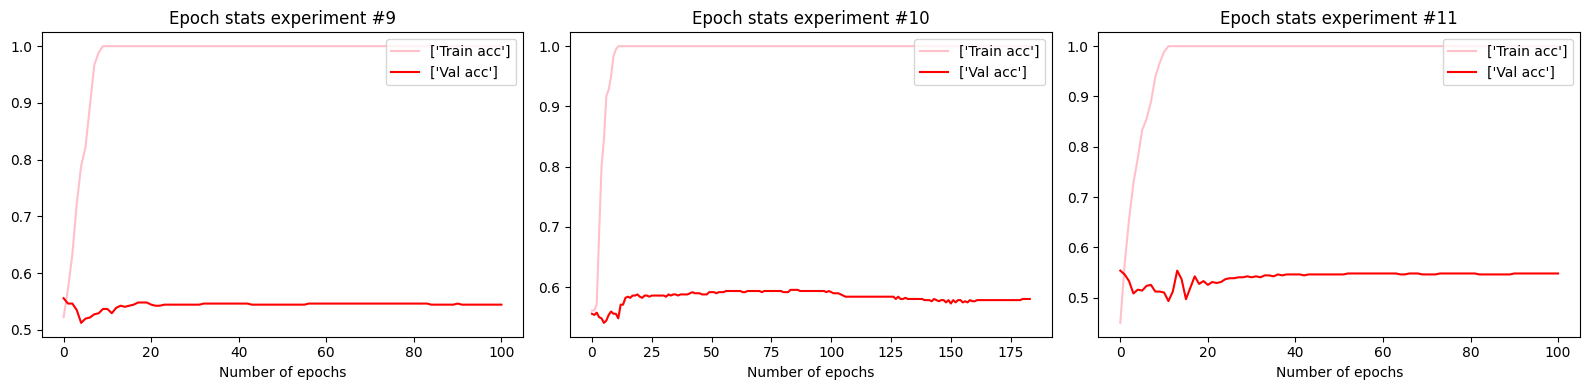

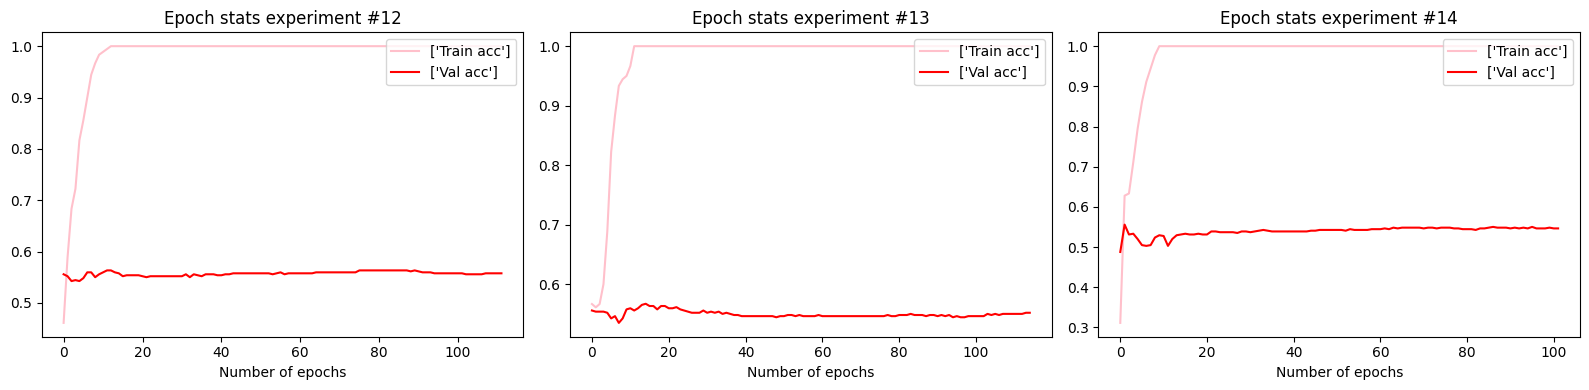

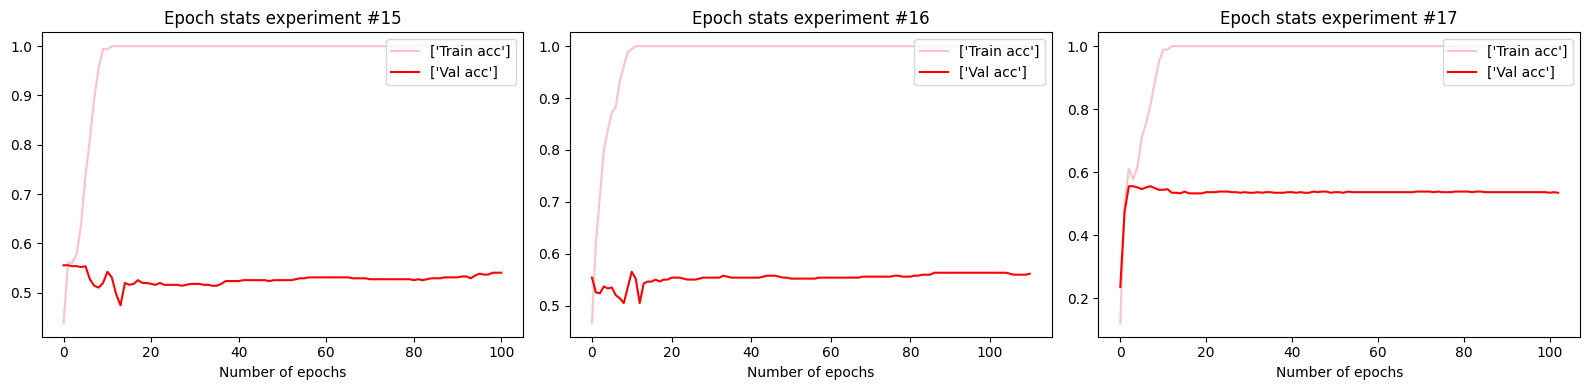

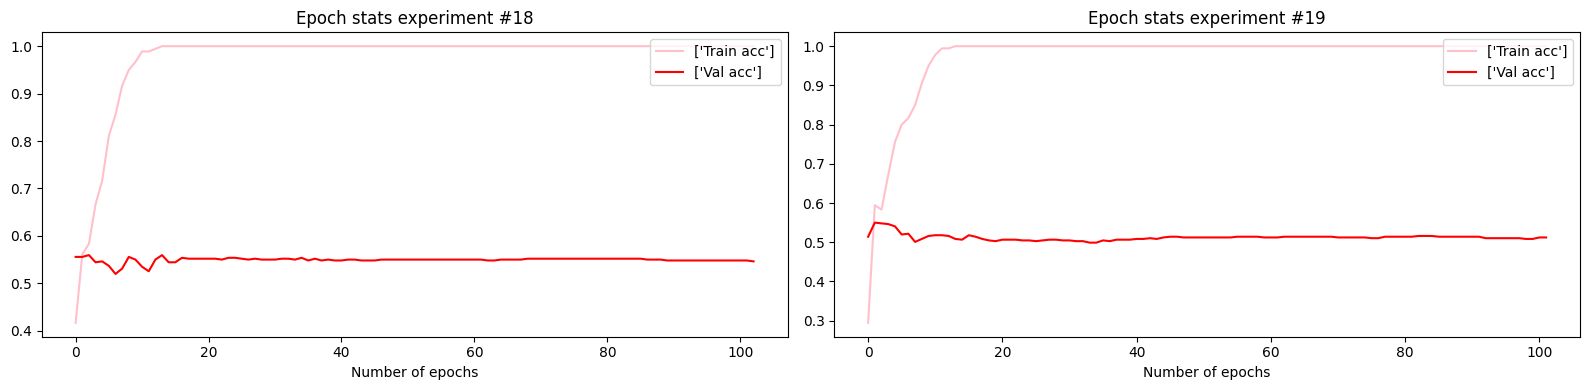

In [37]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

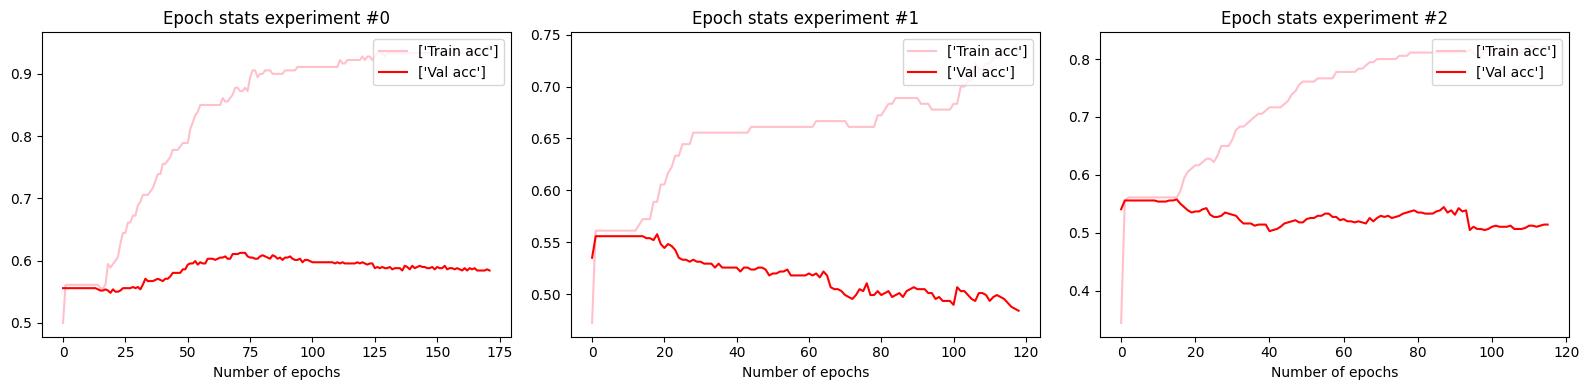

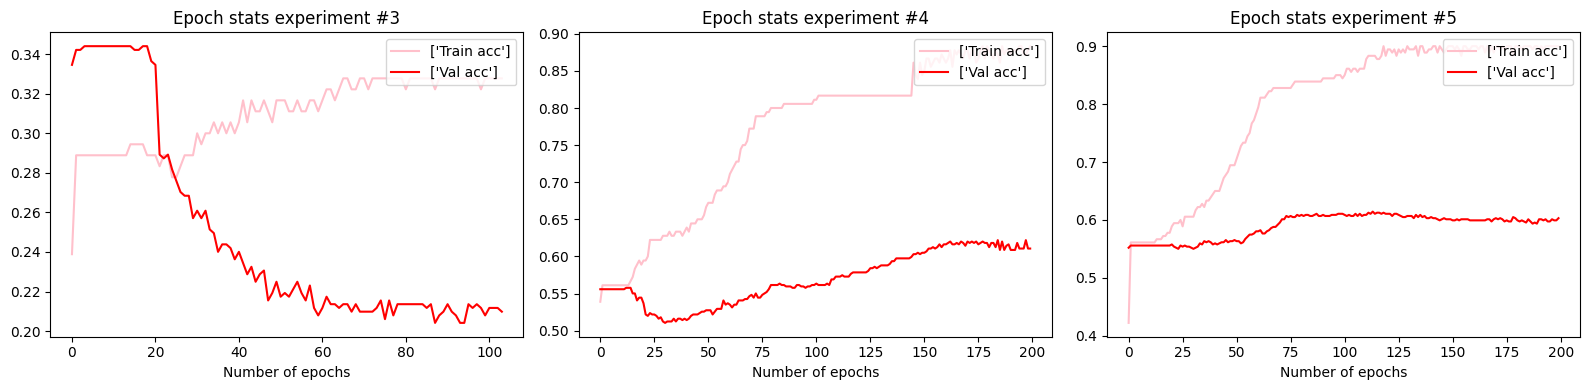

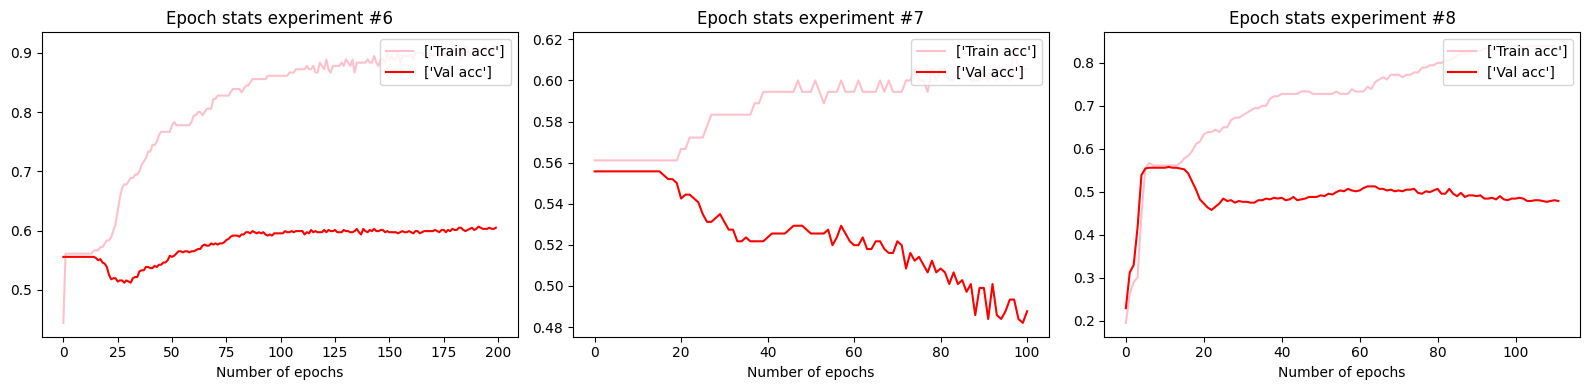

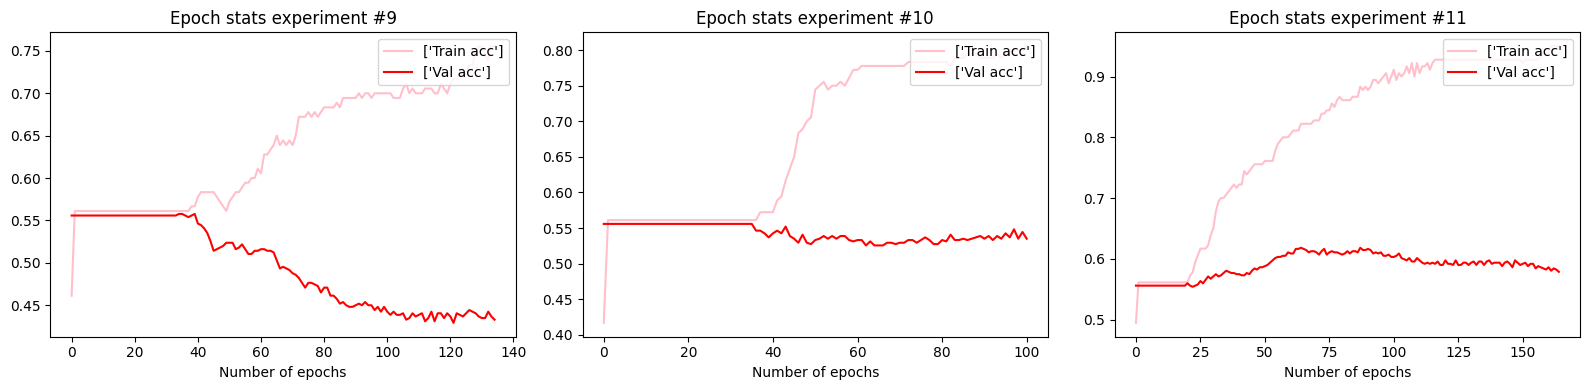

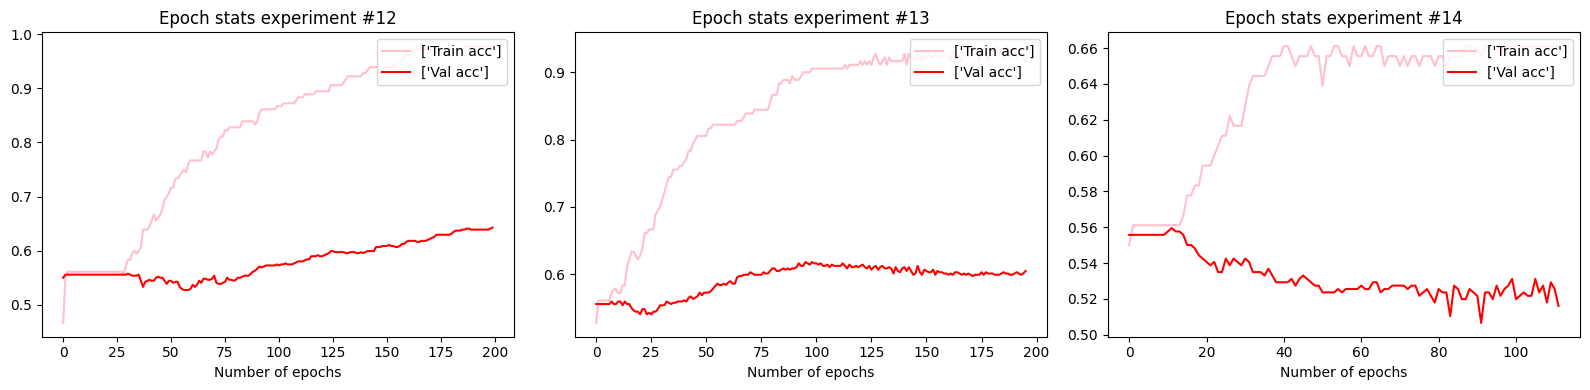

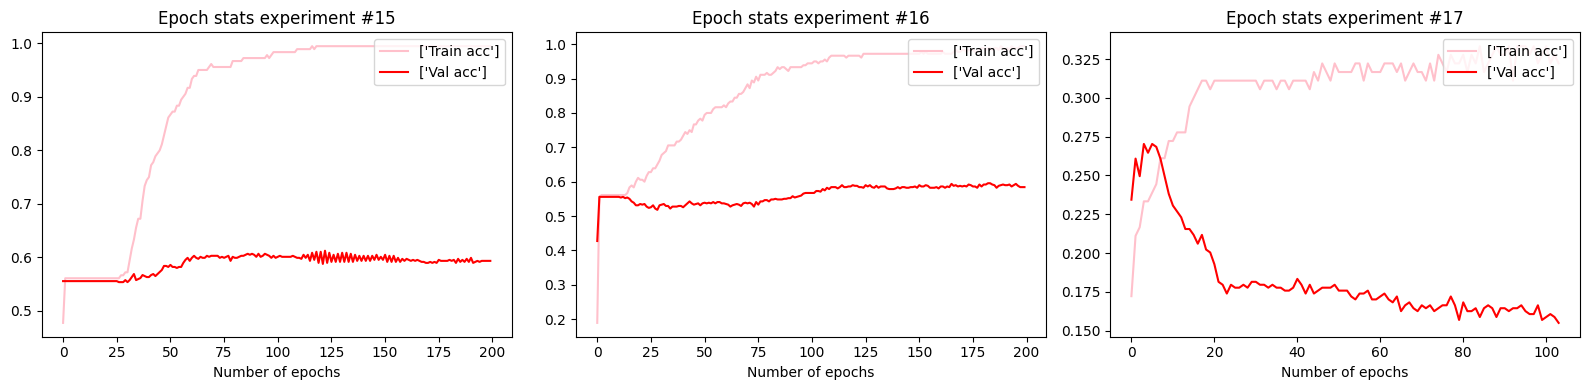

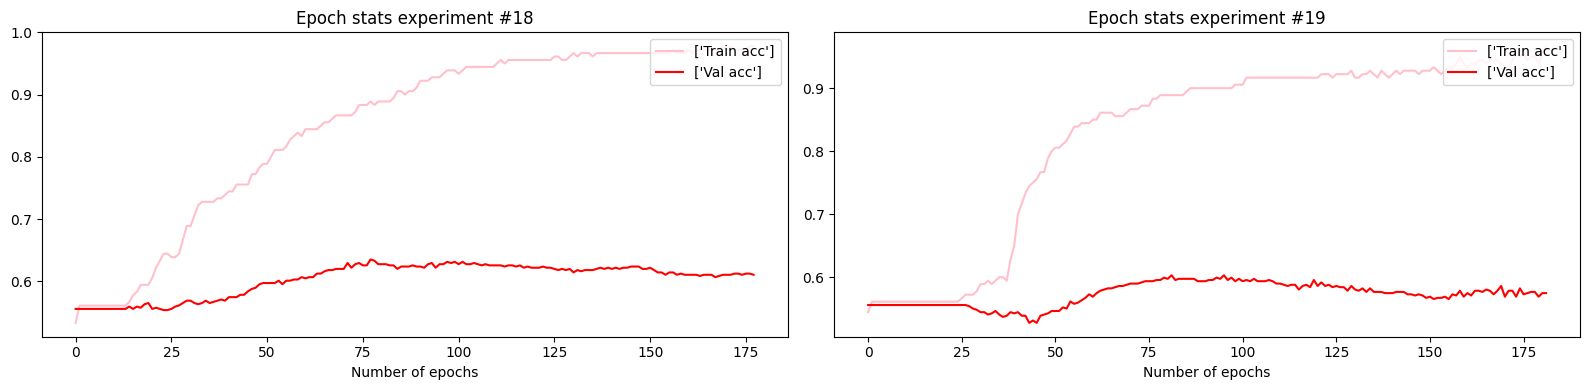

In [38]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

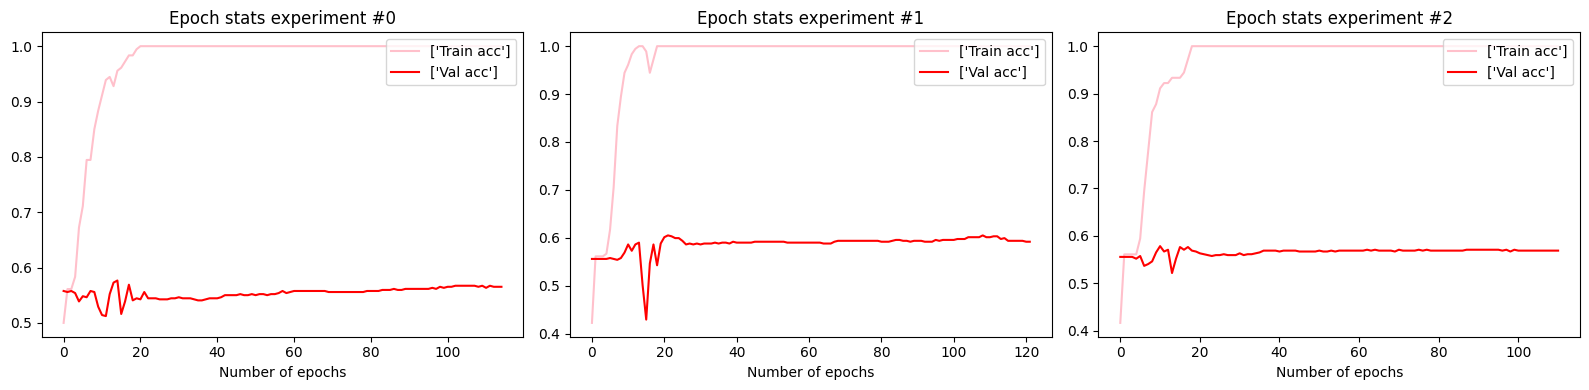

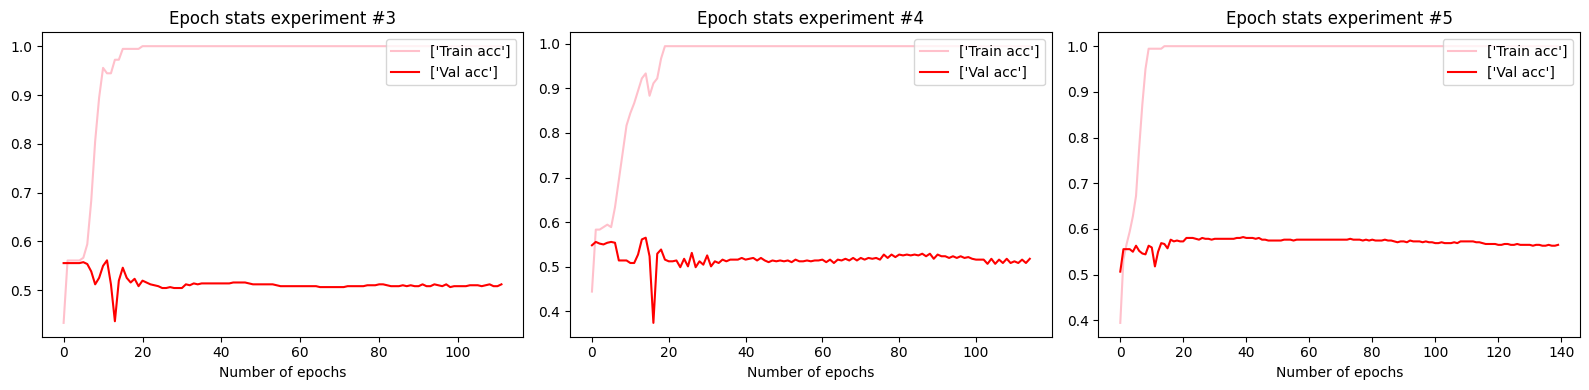

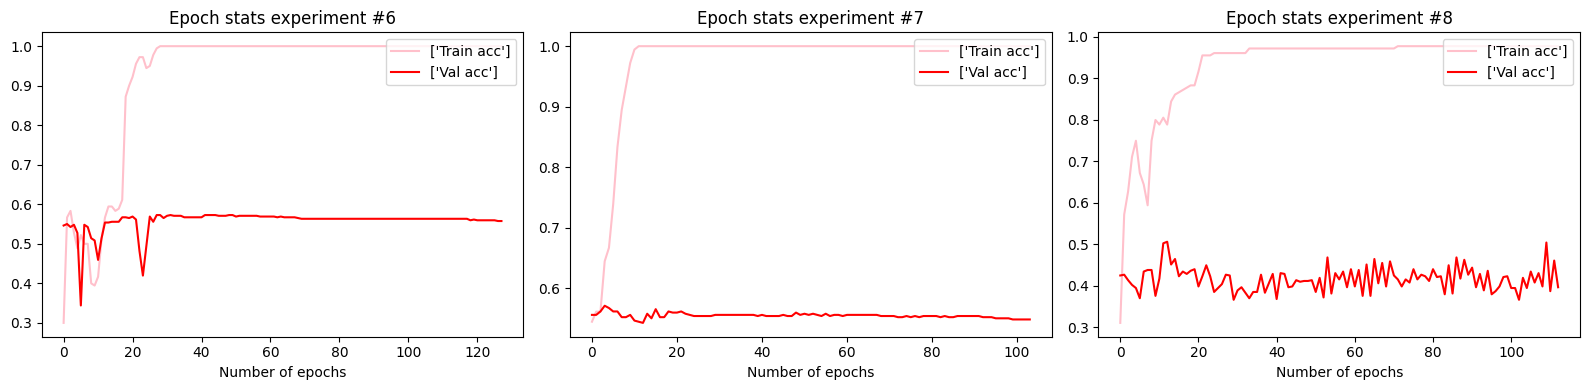

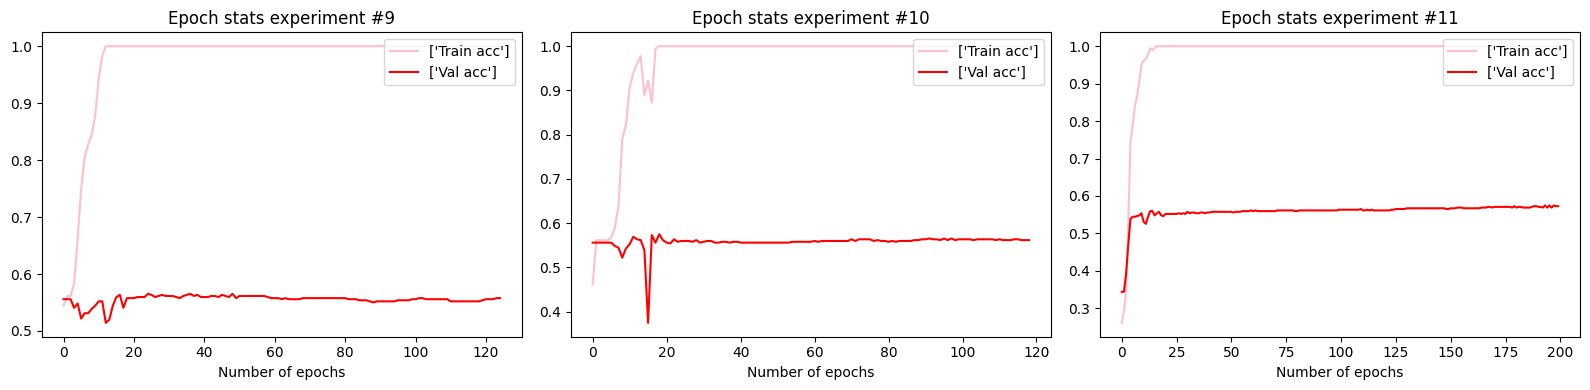

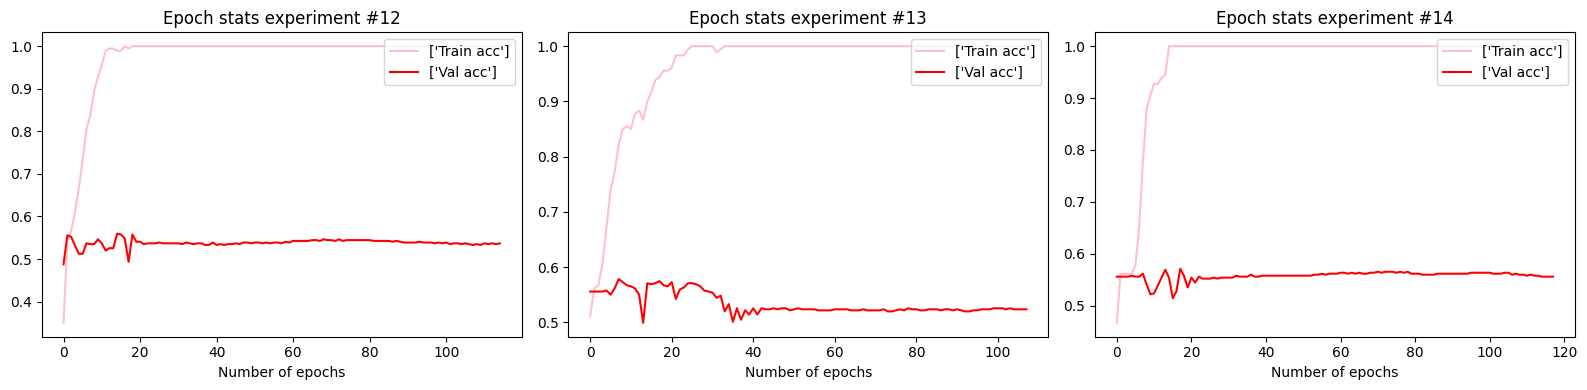

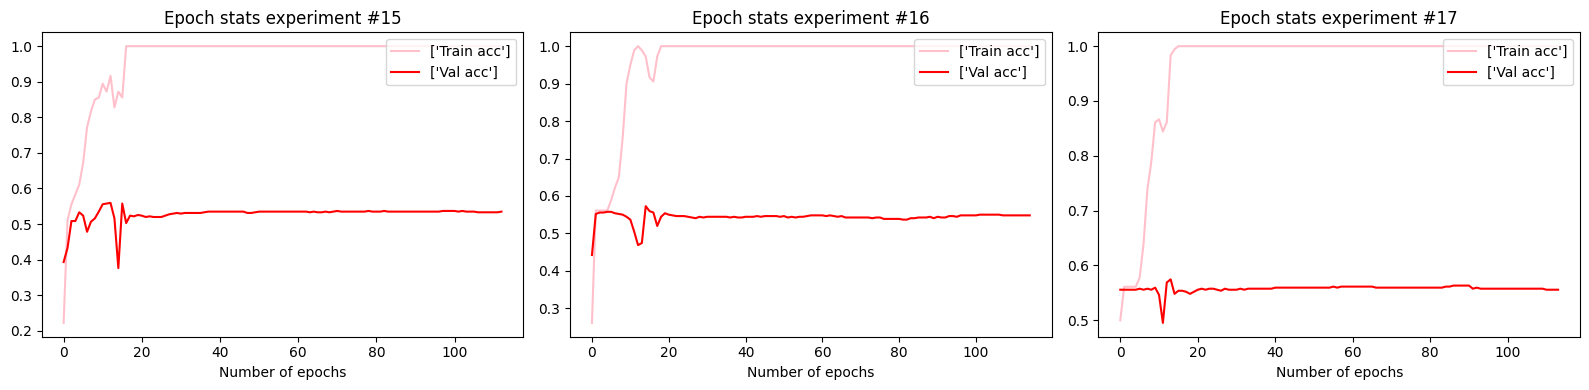

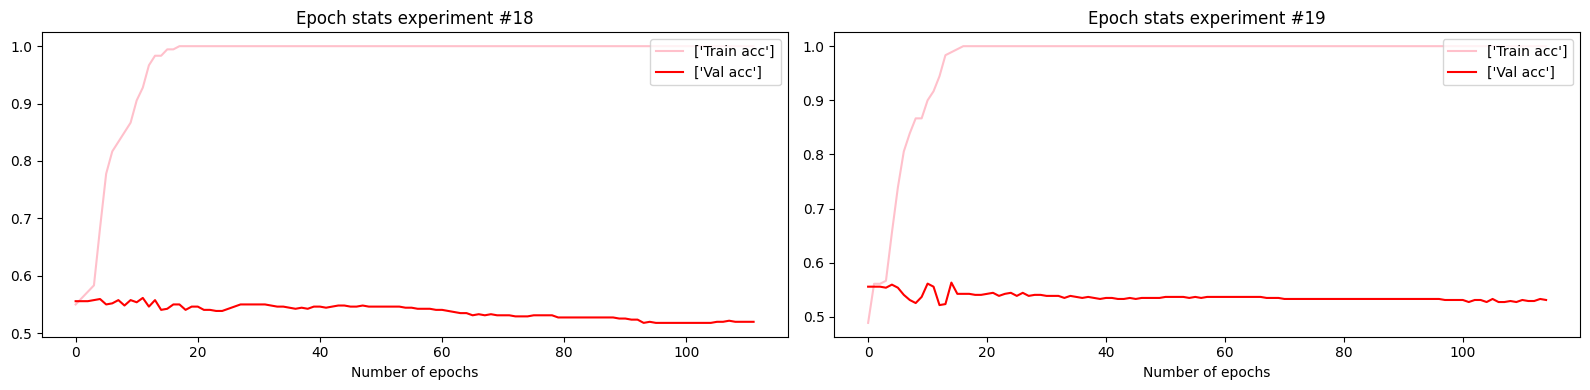

In [43]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [40]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 64, 128, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('best_FEEDFORWARD_model_' + experiment_name))

RuntimeError: Error(s) in loading state_dict for LSTM_Model:
	size mismatch for densef1_1.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for densef1_1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for densef2_1.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for densef2_1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for densef3_1.weight: copying a param with shape torch.Size([16, 16]) from checkpoint, the shape in current model is torch.Size([32, 16]).
	size mismatch for densef3_1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for densef1_2.weight: copying a param with shape torch.Size([8, 16]) from checkpoint, the shape in current model is torch.Size([8, 32]).
	size mismatch for densef2_2.weight: copying a param with shape torch.Size([8, 16]) from checkpoint, the shape in current model is torch.Size([8, 32]).
	size mismatch for densef3_2.weight: copying a param with shape torch.Size([8, 16]) from checkpoint, the shape in current model is torch.Size([8, 32]).

## Top wrong predictions for best performing CNN model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing LSTM model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing DeepSets V1 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing DeepSets V2 model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

## Top wrong predictions for best performing Feedforward model

In [ ]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

# Saving Notebook State

In [ ]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

# Loading Notebook State

In [ ]:
import dill
experiment_name = "all_filters"
# dill.load_session('notebook_env_' + experiment_name + '.db')